In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
lead_data = pd.read_csv('/content/drive/My Drive/IPRO/boots_1.csv')

# Convert 'Sample Date' to datetime, handling errors
lead_data['Sample Date'] = pd.to_datetime(lead_data['Sample Date'], errors='coerce')

In [13]:
# First, let's prepare the lead data by selecting relevant columns
lead_data_clean = lead_data[['Sample Date', '1st Draw', '2/3 Min', '5 Min', 'Max']].copy()

In [14]:
# Convert lead columns to numeric, handling non-numeric values
for col in ['1st Draw', '2/3 Min', '5 Min', 'Max']:
    lead_data_clean[col] = pd.to_numeric(lead_data_clean[col], errors='coerce')

# Create a date column in the same format as the weather data for merging
lead_data_clean['Date'] = lead_data_clean['Sample Date'].dt.date

In [15]:
Chicago_weather_data = pd.read_csv('/content/drive/My Drive/IPRO/Chicago Weather Data.csv')
# Prepare the weather data - create a date column
Chicago_weather_data['Date'] = pd.to_datetime(
    Chicago_weather_data['YEAR'].astype(str) + '-' +
    Chicago_weather_data['MO'].astype(str) + '-' +
    Chicago_weather_data['DY'].astype(str)
).dt.date

In [16]:
# Group weather data by date to get daily averages
daily_weather = Chicago_weather_data.groupby('Date').agg({
    'TEMP': 'mean',
    'PRCP': 'sum',
    'HMDT': 'mean',
    'WND_SPD': 'mean',
    'ATM_PRESS': 'mean'
}).reset_index()

# Merge lead data with weather data
merged_data = pd.merge(lead_data_clean, daily_weather, on='Date', how='inner')

# Check how many samples we have after merging
print(f"Number of samples with matching weather data: {len(merged_data)}")

Number of samples with matching weather data: 18274


In [17]:
# Analyze correlations between lead levels and temperature
correlation_analysis = merged_data.corr(numeric_only=True)

# Create visualizations
plt.figure(figsize=(18, 10))

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

Text(0, 0.5, 'Lead Level (ppb)')

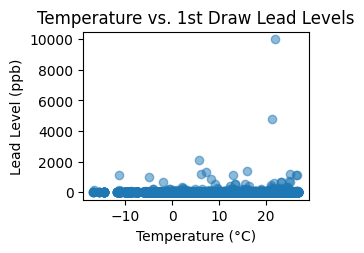

In [18]:
# 1. Scatter plot: Temperature vs. Lead levels
plt.subplot(2, 2, 1)
plt.scatter(merged_data['TEMP'], merged_data['1st Draw'], alpha=0.5)
plt.title('Temperature vs. 1st Draw Lead Levels')
plt.xlabel('Temperature (°C)')
plt.ylabel('Lead Level (ppb)')

Text(0, 0.5, 'Lead Level (ppb)')

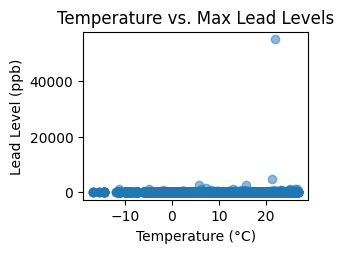

In [19]:
# 2. Scatter plot for Max lead level
plt.subplot(2, 2, 2)
plt.scatter(merged_data['TEMP'], merged_data['Max'], alpha=0.5)
plt.title('Temperature vs. Max Lead Levels')
plt.xlabel('Temperature (°C)')
plt.ylabel('Lead Level (ppb)')

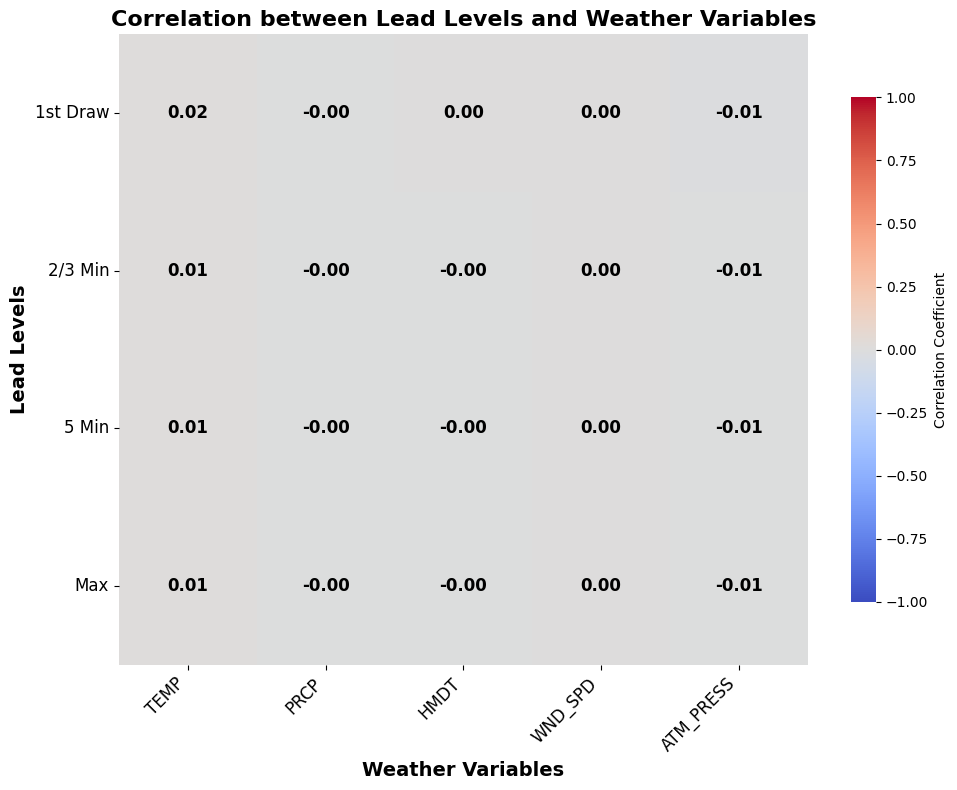

In [24]:
# Enhanced Correlation Heatmap
plt.figure(figsize=(10, 8))  # Set figure size for better readability

# Define columns to include in the heatmap
lead_cols = ['1st Draw', '2/3 Min', '5 Min', 'Max']
weather_cols = ['TEMP', 'PRCP', 'HMDT', 'WND_SPD', 'ATM_PRESS']

# Extract the relevant correlation subset from the full correlation analysis
corr_subset = correlation_analysis.loc[lead_cols, weather_cols]

# Plot the heatmap with improvements
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1,
            cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'},
            annot_kws={'size': 12, 'weight': 'bold', 'color': 'black'})

# Add titles and axis labels
plt.title('Correlation between Lead Levels and Weather Variables', fontsize=16, weight='bold')
plt.xlabel('Weather Variables', fontsize=14, weight='bold')
plt.ylabel('Lead Levels', fontsize=14, weight='bold')

# Improve the appearance of tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()  # Ensure everything fits without overlap
plt.show()


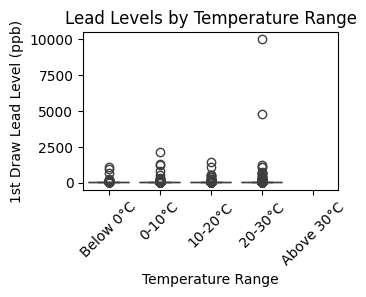

In [21]:
# 4. Boxplot of lead levels by temperature ranges
plt.subplot(2, 2, 4)
# Create temperature bins
merged_data['Temp_Range'] = pd.cut(merged_data['TEMP'],
                                  bins=[-30, 0, 10, 20, 30, 40],
                                  labels=['Below 0°C', '0-10°C', '10-20°C', '20-30°C', 'Above 30°C'])
sns.boxplot(x='Temp_Range', y='1st Draw', data=merged_data)
plt.title('Lead Levels by Temperature Range')
plt.xlabel('Temperature Range')
plt.ylabel('1st Draw Lead Level (ppb)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [22]:
# Detailed statistical analysis
from scipy import stats

# Calculate correlation coefficients and p-values for lead vs temperature
for lead_col in lead_cols:
    # Remove NaN values for valid correlation calculation
    valid_data = merged_data[[lead_col, 'TEMP']].dropna()
    if len(valid_data) > 5:  # Only calculate if we have enough data points
        r, p_value = stats.pearsonr(valid_data[lead_col], valid_data['TEMP'])
        print(f"Correlation between {lead_col} and Temperature: r = {r:.4f}, p-value = {p_value:.4f}")
        if p_value < 0.05:
            print(f"  Statistically significant correlation found (p < 0.05)")
        else:
            print(f"  No statistically significant correlation found (p > 0.05)")
    else:
        print(f"Not enough valid data points to calculate correlation for {lead_col}")

Correlation between 1st Draw and Temperature: r = 0.0150, p-value = 0.0518
  No statistically significant correlation found (p > 0.05)
Correlation between 2/3 Min and Temperature: r = 0.0138, p-value = 0.0734
  No statistically significant correlation found (p > 0.05)
Correlation between 5 Min and Temperature: r = 0.0097, p-value = 0.2086
  No statistically significant correlation found (p > 0.05)
Correlation between Max and Temperature: r = 0.0111, p-value = 0.1508
  No statistically significant correlation found (p > 0.05)


In [23]:
# Linear regression for 1st Draw lead levels vs temperature
from sklearn.linear_model import LinearRegression
import numpy as np

x = merged_data['TEMP'].dropna().values.reshape(-1, 1)
y = merged_data['1st Draw'].dropna().values

# Check if we have enough matched data points for analysis
if len(x) == len(y) and len(x) > 5:
    # Remove any remaining NaN values
    mask = ~np.isnan(y)
    x = x[mask]
    y = y[mask]

    if len(x) > 5:  # Still need enough data after filtering
        model = LinearRegression()
        model.fit(x, y)

        print("\nLinear Regression Analysis:")
        print(f"Slope (Temperature effect on 1st Draw Lead): {model.coef_[0]:.4f}")
        print(f"Intercept: {model.intercept_:.4f}")
        print(f"R² Score: {model.score(x, y):.4f}")
    else:
        print("\nNot enough valid data points for regression analysis after filtering NaNs")
else:
    print("\nNot enough matching data points for regression analysis")


Not enough matching data points for regression analysis
